## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

--2019-10-10 19:50:44--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.186.165
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.186.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  71.9MB/s    in 4.8s    

2019-10-10 19:50:49 (66.9 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: /data/test/Abdullah_Gul_

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.5)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout4): Dropout(p=0.5)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (bn1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout5): Dropout(p=0.5)
  (fc2): Linear(in_features=1000, out_features=136, bias=True)
)


In [13]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

net = net.apply(weights_init)

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [11]:
import cv2

class RandomFlip(object):
    """Perform random horizontal flip the image in a sample.

    Args:
        p: probability of flipping the image horizontally
    """

    def __init__(self, p = 0.5):
        self.p = p

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        
        r = np.random.uniform()
        
        if (r < self.p):
            h, w = image_copy.shape[:2]
            
            image_copy = cv2.flip(image_copy, 1)
            key_pts_copy[:, 0] = w - key_pts_copy[:, 0]

        return {'image': image_copy, 'keypoints': key_pts_copy}

In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([RandomFlip(0.1),
                                     Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [13]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [14]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [15]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [16]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [17]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [18]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [23]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

In [24]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()

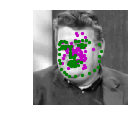

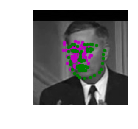

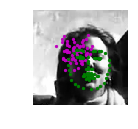

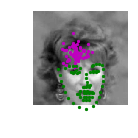

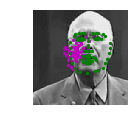

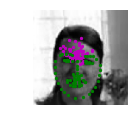

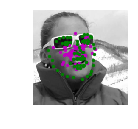

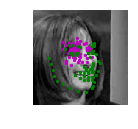

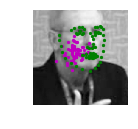

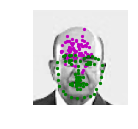

In [23]:
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [24]:
## TODO: Define the loss and optimization
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [25]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
    
    losses = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                
                losses.append(running_loss/10)
                running_loss = 0.0
                
        scheduler.step(running_loss/len(train_loader))

    print('Finished Training')
    
    return losses


In [26]:
# train your network
n_epochs = 20 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    losses = train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.2274577111005783
Epoch: 1, Batch: 20, Avg. Loss: 0.18392062708735465
Epoch: 1, Batch: 30, Avg. Loss: 0.16010650917887687
Epoch: 1, Batch: 40, Avg. Loss: 0.17445312589406967
Epoch: 1, Batch: 50, Avg. Loss: 0.1537548117339611
Epoch: 1, Batch: 60, Avg. Loss: 0.1724431850016117
Epoch: 1, Batch: 70, Avg. Loss: 0.15648002848029136
Epoch: 1, Batch: 80, Avg. Loss: 0.14207539036870004
Epoch: 1, Batch: 90, Avg. Loss: 0.13750477135181427
Epoch: 1, Batch: 100, Avg. Loss: 0.1647557035088539
Epoch: 1, Batch: 110, Avg. Loss: 0.14498911947011947
Epoch: 1, Batch: 120, Avg. Loss: 0.1429263547062874
Epoch: 1, Batch: 130, Avg. Loss: 0.12576258704066276
Epoch: 1, Batch: 140, Avg. Loss: 0.1355268180370331
Epoch: 1, Batch: 150, Avg. Loss: 0.14016622453927993
Epoch: 1, Batch: 160, Avg. Loss: 0.1330551065504551
Epoch: 1, Batch: 170, Avg. Loss: 0.14077514931559562
Epoch: 1, Batch: 180, Avg. Loss: 0.13173203840851783
Epoch: 1, Batch: 190, Avg. Loss: 0.1491268865764141
Epoch: 1, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.11101276278495789
Epoch: 2, Batch: 20, Avg. Loss: 0.10817640312016011
Epoch: 2, Batch: 30, Avg. Loss: 0.11857914254069328
Epoch: 2, Batch: 40, Avg. Loss: 0.11173713132739067
Epoch: 2, Batch: 50, Avg. Loss: 0.0986293949186802
Epoch: 2, Batch: 60, Avg. Loss: 0.14997877255082132
Epoch: 2, Batch: 70, Avg. Loss: 0.11946138888597488
Epoch: 2, Batch: 80, Avg. Loss: 0.10039290338754654
Epoch: 2, Batch: 90, Avg. Loss: 0.08894809521734715
Epoch: 2, Batch: 100, Avg. Loss: 0.11240030303597451
Epoch: 2, Batch: 110, Avg. Loss: 0.10130504742264748
Epoch: 2, Batch: 120, Avg. Loss: 0.09603317938745022
Epoch: 2, Batch: 130, Avg. Loss: 0.10726666450500488
Epoch: 2, Batch: 140, Avg. Loss: 0.12262798175215721
Epoch: 2, Batch: 150, Avg. Loss: 0.12300922237336635
Epoch: 2, Batch: 160, Avg. Loss: 0.10399100482463837
Epoch: 2, Batch: 170, Avg. Loss: 0.11646809615194798
Epoch: 2, Batch: 180, Avg. Loss: 0.11291144825518132
Epoch: 2, Batch: 190, Avg. Loss: 0.09995917156338692
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.10461547262966633
Epoch: 4, Batch: 20, Avg. Loss: 0.10653715506196022
Epoch: 4, Batch: 30, Avg. Loss: 0.10834828540682792
Epoch: 4, Batch: 40, Avg. Loss: 0.08340438380837441
Epoch: 4, Batch: 50, Avg. Loss: 0.0809734683483839
Epoch: 4, Batch: 60, Avg. Loss: 0.12057155221700669
Epoch: 4, Batch: 70, Avg. Loss: 0.10432755872607231
Epoch: 4, Batch: 80, Avg. Loss: 0.09389757812023163
Epoch: 4, Batch: 130, Avg. Loss: 0.08285246305167675
Epoch: 4, Batch: 140, Avg. Loss: 0.13697790279984473
Epoch: 4, Batch: 150, Avg. Loss: 0.10545104555785656
Epoch: 4, Batch: 160, Avg. Loss: 0.10419121235609055
Epoch: 4, Batch: 170, Avg. Loss: 0.10990688651800155
Epoch: 4, Batch: 180, Avg. Loss: 0.11046197637915611
Epoch: 4, Batch: 190, Avg. Loss: 0.09930183887481689
Epoch: 4, Batch: 200, Avg. Loss: 0.10524424277245999
Epoch: 4, Batch: 210, Avg. Loss: 0.10058264657855034
Epoch: 4, Batch: 220, Avg. Loss: 0.11108406707644462
Epoch: 4, Batch: 230, Avg. Loss: 0.08718479573726653
Ep

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.10570958778262138
Epoch: 5, Batch: 20, Avg. Loss: 0.10955115035176277
Epoch: 5, Batch: 30, Avg. Loss: 0.11107041127979755
Epoch: 5, Batch: 40, Avg. Loss: 0.11233355104923248
Epoch: 5, Batch: 50, Avg. Loss: 0.10857004262506961
Epoch: 5, Batch: 60, Avg. Loss: 0.13321708627045153
Epoch: 5, Batch: 70, Avg. Loss: 0.09224160835146904
Epoch: 5, Batch: 80, Avg. Loss: 0.07642578668892383
Epoch: 5, Batch: 90, Avg. Loss: 0.0951866090297699
Epoch: 5, Batch: 100, Avg. Loss: 0.08845230638980865
Epoch: 5, Batch: 110, Avg. Loss: 0.08698596730828285
Epoch: 5, Batch: 120, Avg. Loss: 0.08919216729700566
Epoch: 5, Batch: 130, Avg. Loss: 0.10131702721118926
Epoch: 5, Batch: 140, Avg. Loss: 0.094456522539258
Epoch: 5, Batch: 150, Avg. Loss: 0.10688834339380264
Epoch: 5, Batch: 160, Avg. Loss: 0.10520442947745323
Epoch: 5, Batch: 170, Avg. Loss: 0.08863701745867729
Epoch: 5, Batch: 180, Avg. Loss: 0.08596820384263992
Epoch: 5, Batch: 190, Avg. Loss: 0.08625591434538364
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.0819384079426527
Epoch: 6, Batch: 20, Avg. Loss: 0.10336825884878635
Epoch: 6, Batch: 30, Avg. Loss: 0.13201424926519395
Epoch: 6, Batch: 40, Avg. Loss: 0.08264877088367939
Epoch: 6, Batch: 50, Avg. Loss: 0.08258232735097408
Epoch: 6, Batch: 60, Avg. Loss: 0.11732503212988377
Epoch: 6, Batch: 70, Avg. Loss: 0.06347493305802346
Epoch: 6, Batch: 80, Avg. Loss: 0.09977975338697434
Epoch: 6, Batch: 90, Avg. Loss: 0.08733176663517953
Epoch: 6, Batch: 100, Avg. Loss: 0.09057704024016858
Epoch: 6, Batch: 110, Avg. Loss: 0.09259963110089302
Epoch: 6, Batch: 120, Avg. Loss: 0.11330163031816483
Epoch: 6, Batch: 130, Avg. Loss: 0.1244393240660429
Epoch: 6, Batch: 140, Avg. Loss: 0.11697656661272049
Epoch: 6, Batch: 150, Avg. Loss: 0.09005006439983845
Epoch: 6, Batch: 160, Avg. Loss: 0.10348533317446709
Epoch: 6, Batch: 170, Avg. Loss: 0.0766743179410696
Epoch: 6, Batch: 180, Avg. Loss: 0.10960204526782036
Epoch: 6, Batch: 190, Avg. Loss: 0.09760747328400612
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.10264344103634357
Epoch: 7, Batch: 20, Avg. Loss: 0.09948644302785396
Epoch: 7, Batch: 30, Avg. Loss: 0.09251057766377926
Epoch: 7, Batch: 40, Avg. Loss: 0.09436448737978935
Epoch: 7, Batch: 50, Avg. Loss: 0.085635931417346
Epoch: 7, Batch: 60, Avg. Loss: 0.12420035600662231
Epoch: 7, Batch: 70, Avg. Loss: 0.08376439772546292
Epoch: 7, Batch: 80, Avg. Loss: 0.11581939160823822
Epoch: 7, Batch: 90, Avg. Loss: 0.06504321768879891
Epoch: 7, Batch: 100, Avg. Loss: 0.08663371913135051
Epoch: 7, Batch: 110, Avg. Loss: 0.08215290158987046
Epoch: 7, Batch: 120, Avg. Loss: 0.0722596600651741
Epoch: 7, Batch: 130, Avg. Loss: 0.1023007083684206
Epoch: 7, Batch: 140, Avg. Loss: 0.11016246601939202
Epoch: 7, Batch: 150, Avg. Loss: 0.09052869752049446
Epoch: 7, Batch: 160, Avg. Loss: 0.09100649058818817
Epoch: 7, Batch: 170, Avg. Loss: 0.10429323688149453
Epoch: 7, Batch: 180, Avg. Loss: 0.09544646665453911
Epoch: 7, Batch: 190, Avg. Loss: 0.09338449239730835
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.09966999143362046
Epoch: 8, Batch: 20, Avg. Loss: 0.10312185958027839
Epoch: 8, Batch: 30, Avg. Loss: 0.08904925286769867
Epoch: 8, Batch: 40, Avg. Loss: 0.08974665440618992
Epoch: 8, Batch: 50, Avg. Loss: 0.09590119346976281
Epoch: 8, Batch: 60, Avg. Loss: 0.10772840417921543
Epoch: 8, Batch: 70, Avg. Loss: 0.0745005339384079
Epoch: 8, Batch: 80, Avg. Loss: 0.0738506879657507
Epoch: 8, Batch: 90, Avg. Loss: 0.09180290251970291
Epoch: 8, Batch: 100, Avg. Loss: 0.08525121882557869
Epoch: 8, Batch: 110, Avg. Loss: 0.0789504200220108
Epoch: 8, Batch: 120, Avg. Loss: 0.07638584822416306
Epoch: 8, Batch: 170, Avg. Loss: 0.10542477406561375
Epoch: 8, Batch: 180, Avg. Loss: 0.09791507050395012
Epoch: 8, Batch: 190, Avg. Loss: 0.08854082487523555
Epoch: 8, Batch: 200, Avg. Loss: 0.09769264981150627
Epoch: 8, Batch: 210, Avg. Loss: 0.10633957386016846
Epoch: 8, Batch: 220, Avg. Loss: 0.11055589839816093
Epoch: 8, Batch: 230, Avg. Loss: 0.0807869028300047
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.09607205949723721
Epoch: 9, Batch: 20, Avg. Loss: 0.10485660210251808
Epoch: 9, Batch: 30, Avg. Loss: 0.0879321839660406
Epoch: 9, Batch: 40, Avg. Loss: 0.08334597907960414
Epoch: 9, Batch: 50, Avg. Loss: 0.09625264927744866
Epoch: 9, Batch: 60, Avg. Loss: 0.10399771556258201
Epoch: 9, Batch: 70, Avg. Loss: 0.07190987206995487
Epoch: 9, Batch: 80, Avg. Loss: 0.08180609345436096
Epoch: 9, Batch: 90, Avg. Loss: 0.09807704240083695
Epoch: 9, Batch: 100, Avg. Loss: 0.11701584160327912
Epoch: 9, Batch: 110, Avg. Loss: 0.07712119705975055
Epoch: 9, Batch: 120, Avg. Loss: 0.0716740533709526
Epoch: 9, Batch: 130, Avg. Loss: 0.09727209359407425
Epoch: 9, Batch: 140, Avg. Loss: 0.09923253543674945
Epoch: 9, Batch: 150, Avg. Loss: 0.08344810642302036
Epoch: 9, Batch: 160, Avg. Loss: 0.09762267358601093
Epoch: 9, Batch: 170, Avg. Loss: 0.09851316213607789
Epoch: 9, Batch: 180, Avg. Loss: 0.078797098249197
Epoch: 9, Batch: 190, Avg. Loss: 0.10070222243666649
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.08295895643532276
Epoch: 10, Batch: 20, Avg. Loss: 0.0789915120229125
Epoch: 10, Batch: 30, Avg. Loss: 0.0951768022030592
Epoch: 10, Batch: 40, Avg. Loss: 0.08048364222049713
Epoch: 10, Batch: 50, Avg. Loss: 0.0776721853762865
Epoch: 10, Batch: 60, Avg. Loss: 0.10738926716148853
Epoch: 10, Batch: 70, Avg. Loss: 0.07784396894276142
Epoch: 10, Batch: 80, Avg. Loss: 0.07352216355502605
Epoch: 10, Batch: 90, Avg. Loss: 0.07649569250643254
Epoch: 10, Batch: 100, Avg. Loss: 0.0908253975212574
Epoch: 10, Batch: 110, Avg. Loss: 0.09529373832046986
Epoch: 10, Batch: 120, Avg. Loss: 0.07402908988296986
Epoch: 10, Batch: 130, Avg. Loss: 0.09615026116371155
Epoch: 10, Batch: 140, Avg. Loss: 0.09742443300783635
Epoch: 10, Batch: 150, Avg. Loss: 0.10222142674028874
Epoch: 10, Batch: 160, Avg. Loss: 0.08720723316073417
Epoch: 10, Batch: 170, Avg. Loss: 0.09223905205726624
Epoch: 10, Batch: 180, Avg. Loss: 0.07794679366052151
Epoch: 10, Batch: 190, Avg. Loss: 0.08062

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.09153600372374057
Epoch: 11, Batch: 20, Avg. Loss: 0.08575554899871349
Epoch: 11, Batch: 30, Avg. Loss: 0.08178051076829433
Epoch: 11, Batch: 40, Avg. Loss: 0.07987788952887058
Epoch: 11, Batch: 50, Avg. Loss: 0.0686695210635662
Epoch: 11, Batch: 60, Avg. Loss: 0.11442140340805054
Epoch: 11, Batch: 70, Avg. Loss: 0.06602188982069493
Epoch: 11, Batch: 80, Avg. Loss: 0.0700419306755066
Epoch: 11, Batch: 90, Avg. Loss: 0.09219682477414608
Epoch: 11, Batch: 100, Avg. Loss: 0.09590219967067241
Epoch: 11, Batch: 110, Avg. Loss: 0.09214098565280437
Epoch: 11, Batch: 120, Avg. Loss: 0.07328703459352255
Epoch: 11, Batch: 130, Avg. Loss: 0.07557698823511601
Epoch: 11, Batch: 140, Avg. Loss: 0.07838988825678825
Epoch: 11, Batch: 150, Avg. Loss: 0.1137404389679432
Epoch: 11, Batch: 160, Avg. Loss: 0.09088227413594722
Epoch: 11, Batch: 170, Avg. Loss: 0.09139815866947174
Epoch: 11, Batch: 180, Avg. Loss: 0.08540288768708706
Epoch: 11, Batch: 190, Avg. Loss: 0.0769

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.07895021699368954
Epoch: 12, Batch: 20, Avg. Loss: 0.09400216042995453
Epoch: 12, Batch: 30, Avg. Loss: 0.09658717513084411
Epoch: 12, Batch: 40, Avg. Loss: 0.07709351591765881
Epoch: 12, Batch: 50, Avg. Loss: 0.08594567105174064
Epoch: 12, Batch: 60, Avg. Loss: 0.091047702729702
Epoch: 12, Batch: 70, Avg. Loss: 0.08354367427527905
Epoch: 12, Batch: 80, Avg. Loss: 0.0748626384884119
Epoch: 12, Batch: 90, Avg. Loss: 0.07343321181833744
Epoch: 12, Batch: 100, Avg. Loss: 0.10499577857553959
Epoch: 12, Batch: 110, Avg. Loss: 0.07456164509057998
Epoch: 12, Batch: 120, Avg. Loss: 0.08036989197134972
Epoch: 12, Batch: 130, Avg. Loss: 0.08873888812959194
Epoch: 12, Batch: 140, Avg. Loss: 0.10215217098593712
Epoch: 12, Batch: 150, Avg. Loss: 0.09525848515331745
Epoch: 12, Batch: 160, Avg. Loss: 0.07291721180081367
Epoch: 12, Batch: 170, Avg. Loss: 0.08638987764716148
Epoch: 12, Batch: 210, Avg. Loss: 0.06813719607889653
Epoch: 12, Batch: 220, Avg. Loss: 0.0881

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.09512971192598343
Epoch: 13, Batch: 20, Avg. Loss: 0.07455118522047996
Epoch: 13, Batch: 30, Avg. Loss: 0.10047362074255943
Epoch: 13, Batch: 40, Avg. Loss: 0.07235349752008916
Epoch: 13, Batch: 50, Avg. Loss: 0.08129896074533463
Epoch: 13, Batch: 60, Avg. Loss: 0.09660946503281594
Epoch: 13, Batch: 70, Avg. Loss: 0.07714123129844666
Epoch: 13, Batch: 80, Avg. Loss: 0.07461888007819653
Epoch: 13, Batch: 90, Avg. Loss: 0.0883999664336443
Epoch: 13, Batch: 100, Avg. Loss: 0.11163021400570869
Epoch: 13, Batch: 110, Avg. Loss: 0.09144954793155194
Epoch: 13, Batch: 120, Avg. Loss: 0.07315290495753288
Epoch: 13, Batch: 130, Avg. Loss: 0.0934297613799572
Epoch: 13, Batch: 140, Avg. Loss: 0.09710288979113102
Epoch: 13, Batch: 150, Avg. Loss: 0.09844895824790001
Epoch: 13, Batch: 160, Avg. Loss: 0.08298614211380481
Epoch: 13, Batch: 170, Avg. Loss: 0.07767760641872883
Epoch: 13, Batch: 180, Avg. Loss: 0.10911254286766052
Epoch: 13, Batch: 190, Avg. Loss: 0.095

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.08897767327725888
Epoch: 14, Batch: 20, Avg. Loss: 0.09695089310407638
Epoch: 14, Batch: 30, Avg. Loss: 0.10533956550061703
Epoch: 14, Batch: 40, Avg. Loss: 0.08125523030757904
Epoch: 14, Batch: 50, Avg. Loss: 0.08471853472292423
Epoch: 14, Batch: 60, Avg. Loss: 0.09612115398049355
Epoch: 14, Batch: 70, Avg. Loss: 0.07367398627102376
Epoch: 14, Batch: 80, Avg. Loss: 0.06284968554973602
Epoch: 14, Batch: 90, Avg. Loss: 0.07041533775627613
Epoch: 14, Batch: 100, Avg. Loss: 0.10291741043329239
Epoch: 14, Batch: 110, Avg. Loss: 0.09826515540480614
Epoch: 14, Batch: 120, Avg. Loss: 0.08662540689110756
Epoch: 14, Batch: 130, Avg. Loss: 0.07122251689434052
Epoch: 14, Batch: 140, Avg. Loss: 0.0987652875483036
Epoch: 14, Batch: 150, Avg. Loss: 0.11324048303067684
Epoch: 14, Batch: 160, Avg. Loss: 0.1026038721203804
Epoch: 14, Batch: 170, Avg. Loss: 0.07135892920196056
Epoch: 14, Batch: 180, Avg. Loss: 0.09289209693670272
Epoch: 14, Batch: 190, Avg. Loss: 0.077

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.0775446429848671
Epoch: 15, Batch: 20, Avg. Loss: 0.09660455174744129
Epoch: 15, Batch: 30, Avg. Loss: 0.07346899285912514
Epoch: 15, Batch: 40, Avg. Loss: 0.08484780304133892
Epoch: 15, Batch: 50, Avg. Loss: 0.08376242592930794
Epoch: 15, Batch: 60, Avg. Loss: 0.10185168758034706
Epoch: 15, Batch: 70, Avg. Loss: 0.06346262954175472
Epoch: 15, Batch: 80, Avg. Loss: 0.057751885056495665
Epoch: 15, Batch: 90, Avg. Loss: 0.0998005535453558
Epoch: 15, Batch: 100, Avg. Loss: 0.08140069358050823
Epoch: 15, Batch: 110, Avg. Loss: 0.07858785204589366
Epoch: 15, Batch: 120, Avg. Loss: 0.06972784027457238
Epoch: 15, Batch: 130, Avg. Loss: 0.09113419093191624
Epoch: 15, Batch: 140, Avg. Loss: 0.08220508769154548
Epoch: 15, Batch: 150, Avg. Loss: 0.0833332896232605
Epoch: 15, Batch: 160, Avg. Loss: 0.08700533621013165
Epoch: 15, Batch: 170, Avg. Loss: 0.09007270596921443
Epoch: 15, Batch: 180, Avg. Loss: 0.09266503788530826
Epoch: 15, Batch: 190, Avg. Loss: 0.086

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.08100438341498375
Epoch: 16, Batch: 20, Avg. Loss: 0.07557500042021274
Epoch: 16, Batch: 30, Avg. Loss: 0.10329650640487671
Epoch: 16, Batch: 40, Avg. Loss: 0.08888982608914375
Epoch: 16, Batch: 50, Avg. Loss: 0.07282710708677768
Epoch: 16, Batch: 60, Avg. Loss: 0.09533842355012893
Epoch: 16, Batch: 70, Avg. Loss: 0.08473628424108029
Epoch: 16, Batch: 80, Avg. Loss: 0.07078984379768372
Epoch: 16, Batch: 90, Avg. Loss: 0.07382746897637844
Epoch: 16, Batch: 100, Avg. Loss: 0.1053835105150938
Epoch: 16, Batch: 110, Avg. Loss: 0.07918758355081082
Epoch: 16, Batch: 120, Avg. Loss: 0.08017471134662628
Epoch: 16, Batch: 130, Avg. Loss: 0.08029430322349071
Epoch: 16, Batch: 140, Avg. Loss: 0.09847569167613983
Epoch: 16, Batch: 150, Avg. Loss: 0.10065332613885403
Epoch: 16, Batch: 160, Avg. Loss: 0.09283436313271523
Epoch: 16, Batch: 170, Avg. Loss: 0.08970294818282128
Epoch: 16, Batch: 180, Avg. Loss: 0.0844808604568243
Epoch: 16, Batch: 190, Avg. Loss: 0.083

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.08272282853722572
Epoch: 17, Batch: 20, Avg. Loss: 0.08014487288892269
Epoch: 17, Batch: 30, Avg. Loss: 0.0762415036559105
Epoch: 17, Batch: 40, Avg. Loss: 0.07742259167134762
Epoch: 17, Batch: 50, Avg. Loss: 0.0852226585149765
Epoch: 17, Batch: 60, Avg. Loss: 0.10101624466478824
Epoch: 17, Batch: 70, Avg. Loss: 0.07966053150594235
Epoch: 17, Batch: 80, Avg. Loss: 0.08164767362177372
Epoch: 17, Batch: 90, Avg. Loss: 0.07666248604655265
Epoch: 17, Batch: 100, Avg. Loss: 0.11416398659348488
Epoch: 17, Batch: 110, Avg. Loss: 0.08008965477347374
Epoch: 17, Batch: 120, Avg. Loss: 0.06586005836725235
Epoch: 17, Batch: 130, Avg. Loss: 0.0925629384815693
Epoch: 17, Batch: 140, Avg. Loss: 0.07731979601085186
Epoch: 17, Batch: 150, Avg. Loss: 0.09194817058742047
Epoch: 17, Batch: 160, Avg. Loss: 0.07040975727140904
Epoch: 17, Batch: 170, Avg. Loss: 0.0859835259616375
Epoch: 17, Batch: 180, Avg. Loss: 0.08512099273502827
Epoch: 17, Batch: 190, Avg. Loss: 0.08598

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.08270956724882125
Epoch: 18, Batch: 20, Avg. Loss: 0.0837615229189396
Epoch: 18, Batch: 30, Avg. Loss: 0.09576705396175385
Epoch: 18, Batch: 40, Avg. Loss: 0.07479701861739159
Epoch: 18, Batch: 50, Avg. Loss: 0.07573465593159198
Epoch: 18, Batch: 60, Avg. Loss: 0.07993291057646275
Epoch: 18, Batch: 70, Avg. Loss: 0.07826325483620167
Epoch: 18, Batch: 80, Avg. Loss: 0.08113802075386048
Epoch: 18, Batch: 90, Avg. Loss: 0.09670408256351948
Epoch: 18, Batch: 100, Avg. Loss: 0.10698342993855477
Epoch: 18, Batch: 110, Avg. Loss: 0.07194810137152671
Epoch: 18, Batch: 120, Avg. Loss: 0.08115235529839993
Epoch: 18, Batch: 130, Avg. Loss: 0.07300114408135414
Epoch: 18, Batch: 140, Avg. Loss: 0.07408847361803055
Epoch: 18, Batch: 150, Avg. Loss: 0.08068696260452271
Epoch: 18, Batch: 160, Avg. Loss: 0.10247062519192696
Epoch: 18, Batch: 170, Avg. Loss: 0.08064670115709305
Epoch: 18, Batch: 180, Avg. Loss: 0.10023492835462093
Epoch: 18, Batch: 190, Avg. Loss: 0.07

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.09230605661869049
Epoch: 19, Batch: 20, Avg. Loss: 0.07105664387345315
Epoch: 19, Batch: 30, Avg. Loss: 0.09125786758959294
Epoch: 19, Batch: 40, Avg. Loss: 0.0962445791810751
Epoch: 19, Batch: 50, Avg. Loss: 0.09317424707114697
Epoch: 19, Batch: 60, Avg. Loss: 0.11786344721913337
Epoch: 19, Batch: 70, Avg. Loss: 0.07944810464978218
Epoch: 19, Batch: 80, Avg. Loss: 0.08734216578304768
Epoch: 19, Batch: 90, Avg. Loss: 0.07868939712643623
Epoch: 19, Batch: 100, Avg. Loss: 0.09226941205561161
Epoch: 19, Batch: 110, Avg. Loss: 0.06654699817299843
Epoch: 19, Batch: 120, Avg. Loss: 0.05732446536421776
Epoch: 19, Batch: 130, Avg. Loss: 0.07318626027554273
Epoch: 19, Batch: 140, Avg. Loss: 0.0987558864057064
Epoch: 19, Batch: 150, Avg. Loss: 0.10896442607045173
Epoch: 19, Batch: 160, Avg. Loss: 0.0928579680621624
Epoch: 19, Batch: 170, Avg. Loss: 0.09574288204312324
Epoch: 19, Batch: 180, Avg. Loss: 0.08956844098865986
Epoch: 19, Batch: 190, Avg. Loss: 0.0825

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.08325419723987579
Epoch: 20, Batch: 20, Avg. Loss: 0.09287258945405483
Epoch: 20, Batch: 30, Avg. Loss: 0.08323866501450539
Epoch: 20, Batch: 40, Avg. Loss: 0.07108473852276802
Epoch: 20, Batch: 50, Avg. Loss: 0.06393798664212227
Epoch: 20, Batch: 60, Avg. Loss: 0.10241615772247314
Epoch: 20, Batch: 70, Avg. Loss: 0.07512980476021766
Epoch: 20, Batch: 80, Avg. Loss: 0.08376728929579258
Epoch: 20, Batch: 90, Avg. Loss: 0.08037126325070858
Epoch: 20, Batch: 100, Avg. Loss: 0.0855163350701332
Epoch: 20, Batch: 110, Avg. Loss: 0.08540011383593082
Epoch: 20, Batch: 120, Avg. Loss: 0.07164518088102341
Epoch: 20, Batch: 130, Avg. Loss: 0.07702167108654975
Epoch: 20, Batch: 140, Avg. Loss: 0.0895978033542633
Epoch: 20, Batch: 150, Avg. Loss: 0.08799273148179054
Epoch: 20, Batch: 160, Avg. Loss: 0.08327634967863559
Epoch: 20, Batch: 170, Avg. Loss: 0.07743631079792976
Epoch: 20, Batch: 180, Avg. Loss: 0.08212625384330749
Epoch: 20, Batch: 190, Avg. Loss: 0.067

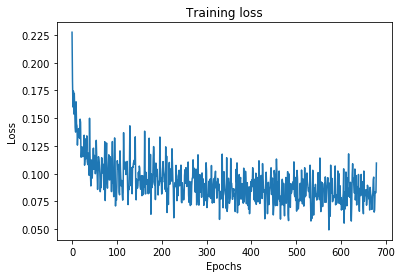

In [27]:
# plot losses
plt.plot(losses)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [19]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


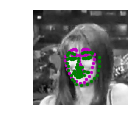

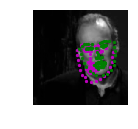

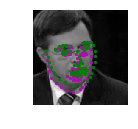

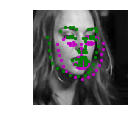

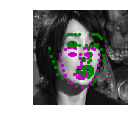

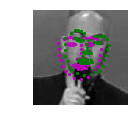

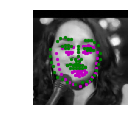

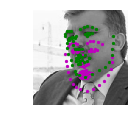

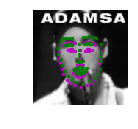

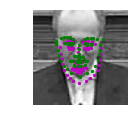

In [25]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [5]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_5.pt'

In [30]:
# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**:

* I chose __Adam optimizer__, because it generally helps to reach the optimum faster.
* I added __learning rate scheduler, which reduces the learning rate on plateau__, because I noticed, that at some point the loss is stuck, and some learning rate adjustments are needed to make further optimization. __Learning rate 0.001__ is the best value to start training with. It helps to optimize the loss gradually without skipping over the optimum (0.01 is too big).
* I chose __Smooth L1Loss__ (which is actually a combination of L2 and L1 loss), because this loss function generalizes better. MSELoss penaltizes at a square rate, that is why it leads to overfitting.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**:

* I used the CNN network architecture described in [this paper](https://arxiv.org/pdf/1710.00977.pdf).
* I added __batch normalization__ after the first fully-connected layer to make weight optimization converge faster. Batch normalization also has very __slight regularization effect__ so much needed for this task.
* To avoid overfitting I also __added another transformation__: random horizontal flipping of the image. This helps to increase the training set with new augmented images, and eventually, leads to better generalization.
* I added __xavier weights initialization__ so that a particular input signal does not get too big or too small as the network trains. 

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:
* I tried 2 models with 96 x 96 input images and 224 x 224 input images. __Batch size 32 worked best with 96 x 96 input model__. This batch size helped to converge to somewhat good results in just 7-10 epochs. After 7-10 epochs training loss reaches optimum and just stops decreasing.
* __Batch size 10 is the only batch size, which worked with 224 x 224__ images (greater batch size just gives bus error). It took __15-20 epochs to train the model__ to achieve decent results for 224 x 224 input images. After 20 epochs the training loss stopped decreasing (as it is so close to the optimum).

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [6]:
# load the model from weights

checkpoint = torch.load(model_dir+model_name)
net.load_state_dict(checkpoint)

[[ 0.12441838 -0.09971813 -0.08978336  0.00322293]
 [-0.01680218 -0.03953945 -0.08976826  0.12388783]
 [ 0.0363804  -0.00214107 -0.01475789  0.01150959]
 [-0.0073413  -0.08165215 -0.07061765  0.0835985 ]]
(4, 4)


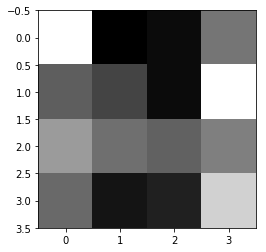

In [26]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 1

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


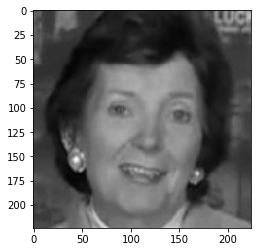

In [46]:
##TODO: load in and display any image from the transformed test dataset

# initialize the dataset
face_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/')
# get a random image index
img_num = np.random.randint(len(face_dataset))

# setup the transforms (all except the ToTensor())
transformations = transforms.Compose([RandomFlip(0.1),
                                     Rescale(250),
                                     RandomCrop(224),
                                     Normalize()])

# get the transformed image
transformed_image = transformations(face_dataset[img_num])['image']

plt.imshow(transformed_image, cmap = 'gray')

In [59]:
def plot_filter(transformed_image, filter_index):
    c = cv2.filter2D(transformed_image, -1, w[filter_index][0])

    fig, axs = plt.subplots(1, 2, figsize=(10, 10))

    axs[0].imshow(w[filter_index][0], cmap='gray')
    axs[0].set_title('Filter')
    axs[0].set_title('Filter')
    axs[0].axis('off')

    axs[1].imshow(c, cmap='gray')
    axs[1].set_title('Filtered image')
    axs[1].axis('off')

    plt.show()

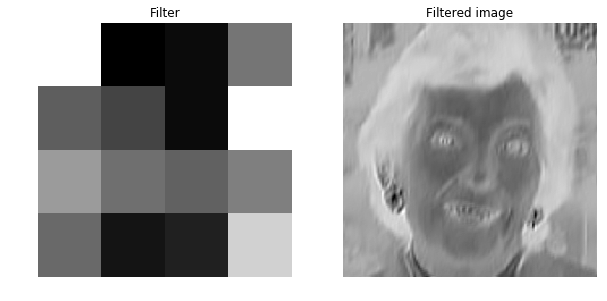

In [61]:
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

filter_index = 1

plot_filter(transformed_image, filter_index)

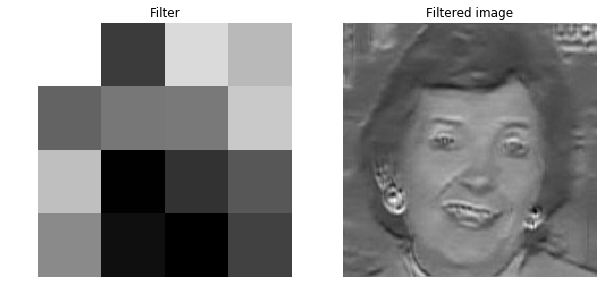

In [67]:
filter_index = 6

plot_filter(transformed_image, filter_index)

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**:
* I applied several filters. The most demonstrative was the example number 6 (see above). This filter __highlights horizontal lines__.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!